In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json

In [23]:
#sns.set_style("whitegrid")
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [6, 6]
sns.set_palette("muted")
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [24]:
res_dir="results/1111optuna"
res_dir="results/1113optuna"
json_files = glob.glob(res_dir+'/*.json')

#res_dir="results/1113optuna_gpt"
#json_files = glob.glob(res_dir+'/*_gpt.json')



print(len(json_files))
res_list=[]
for json_file in json_files:
    res=json.load(open(json_file))

    for record in res:
        qa_log=record['pred_log']

        score_list={
        "multi":[],
        "gen":[],
        #"gen(GPT)":[],
        "mmlu":[],
        }
       
           
       
        for qa in qa_log:
            if qa["question_type"]=="mmlu":
                score_list["mmlu"].append(qa["score"])
            elif qa["question_type"]=="original":
                if qa["type"]=="gen":
                    score_list["gen"].append(qa["score"])
                elif qa["type"]=="multi":
                    score_list["multi"].append(qa["score"])

        for key in score_list:
            record[key]=np.mean(score_list[key])
        
        #record["gen(GPT)"]=record["gen(GPT)"]/10
        n_texts=0
        for k,v in record["n_contexts_dict"].items():
            record[k]=v
            n_texts+=v

        n_texts+=record["n_instructions"]+record["n_mmlu_instructions"]
        record["Total texts"]=n_texts
        record["Total instructions"]=record["n_instructions"]
        record["MMLU"]=record["n_mmlu_instructions"]
    res_list.extend(res)

18


In [25]:
df=pd.DataFrame(res_list)

df=df.sort_values(by="epoch",ascending=True)
df["LoRA layers"]=df["target_layers"].astype(str).str.count(",")
df_=df.copy()
df=df.drop(columns=["pred_log","n_contexts_dict","model_name",
"total_epochs","inner_epochs","model_dir","dataset",
  'per_device_train_batch_size', "n_mmlu_instructions","n_instructions",
  #'r',
   #'lr', 
   #'lora_alpha', 
  "target_layers","initial_eval","loss_dict","bit",
])

#df["condition"]=df["model_size"].astype(str)+"-"+df["bit"].astype(str)+"bit"\
#    +"-c"+df["num_train_contexts"].astype(str)\
#        +"-i"+df["num_train_instructions"].astype(str)+"-"+df["dataset"]
df=df.sort_values(by=["model_size"])
df

,r,lr,lora_alpha,model_size,score,epoch,multi,gen,mmlu,Abstract (target),...,Conclusion (target),Abstract (irrelevant 1),Introduction (irrelevant 1),Introduction-multi (irrelevant 1),Conclusion (irrelevant 1),Introduction (irrelevant 2),Total texts,Total instructions,MMLU,LoRA layers
0,116,7.071974e-05,121,7,0.000155,1,0.256198,0.000155,0.12,46,...,167,18,12347,3504,1403,30092,48464,537,4,8
185,54,3.674228e-07,328,7,0.105131,3,0.826446,0.105131,0.36,35,...,213,24,7,110,75,1,2250,406,762,8
216,61,3.638401e-05,1010,7,0.060807,3,0.685950,0.060807,0.28,8,...,500,3,7163,1,1,74,8563,3,27,4
243,62,5.414456e-05,600,7,0.140832,3,0.793388,0.140832,0.32,30,...,166,150,133,3252,69,29,4862,84,5,4
251,61,5.075354e-05,674,7,0.124295,3,0.834711,0.124295,0.22,13,...,49,174,303,7490,19,11,8667,133,20,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,100,3.079792e-04,300,13,0.116103,3,0.561983,0.116103,0.26,1,...,1,1,1,1,1,1,1009,1,1,4
10,115,4.766880e-05,484,13,0.096575,1,0.661157,0.096575,0.26,3,...,1,2,16,136366,34,92,136844,1,1,4
12,115,4.766880e-05,484,13,0.073361,3,0.595041,0.073361,0.24,3,...,1,2,16,136366,34,92,136844,1,1,4
78,151,3.304968e-04,677,13,0.026067,4,0.289256,0.026067,0.32,2,...,2,3,2,3,5,618,838,4,36,4


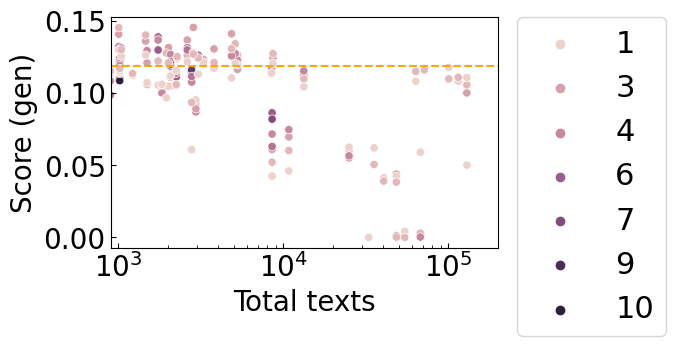

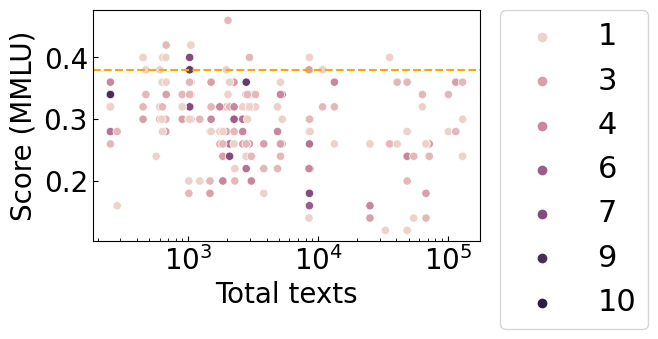

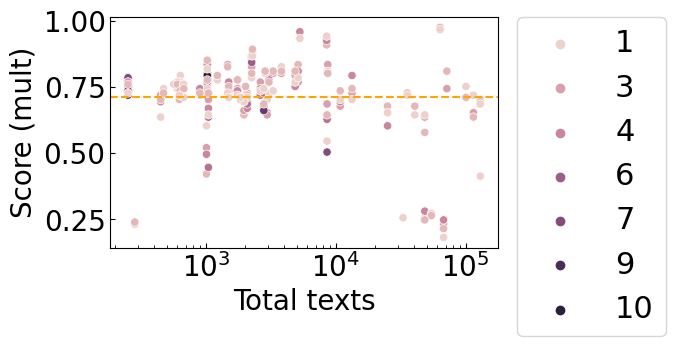

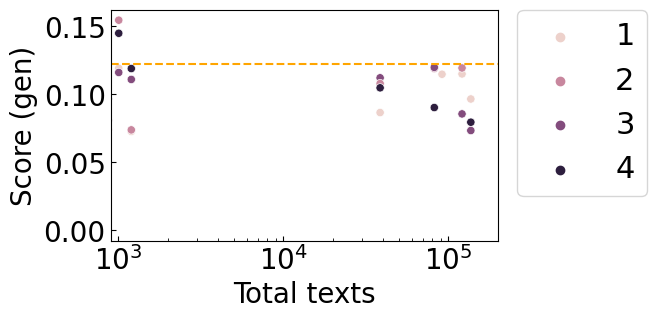

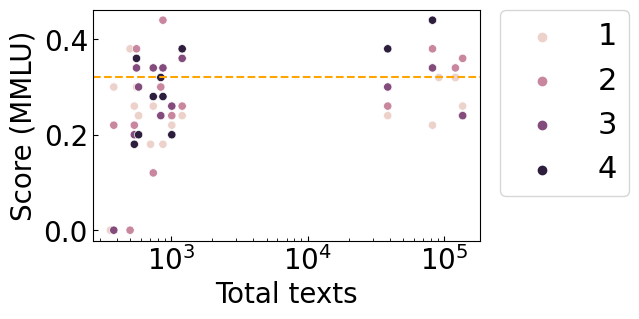

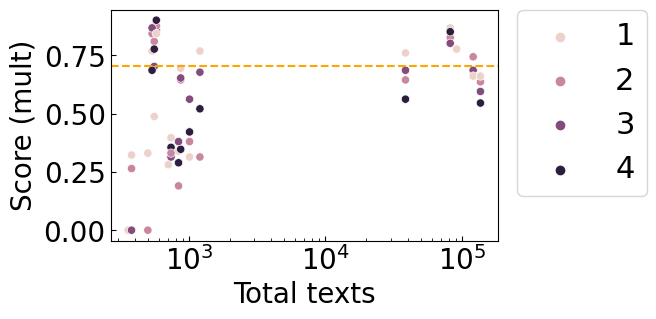

In [26]:
# scores wo training
baseline_dict = {
    7: 0.118755,
    13: 0.122524,
    70: 0.121305,
}
multi_baseline_dict={
7:0.710744,
13:0.702479,
70:0.685950
}
mmlu_baseline_dict={
7:0.38,
13:0.32,
70:0.30,
}


for size in [7,13,]:
    baseline=baseline_dict[size]

    #gen gpt
    plt.figure(figsize=(5,3))
    df_size=df[df["model_size"]==size]
    sns.scatterplot(data=df_size,x="Total texts",y="gen",hue="epoch")
    plt.xscale("log")
    plt.xlim(900,2*10**5)
    plt.axhline(y=baseline, color='orange', linestyle='--')
    plt.ylabel("Score (gen)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=22)


    #mmlu
    plt.figure(figsize=(5,3))
    df_size=df[df["model_size"]==size]
    sns.scatterplot(data=df_size,x="Total texts",y="mmlu",hue="epoch")
    plt.xscale("log")
    baseline=mmlu_baseline_dict[size]
    plt.axhline(y=baseline, color='orange', linestyle='--')
    plt.ylabel("Score (MMLU)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=22)

    #mmlu
    plt.figure(figsize=(5,3))
    df_size=df[df["model_size"]==size]
    sns.scatterplot(data=df_size,x="Total texts",y="multi",hue="epoch")
    plt.xscale("log")
    baseline=multi_baseline_dict[size]
    plt.axhline(y=baseline, color='orange', linestyle='--')
    plt.ylabel("Score (mult)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=22)




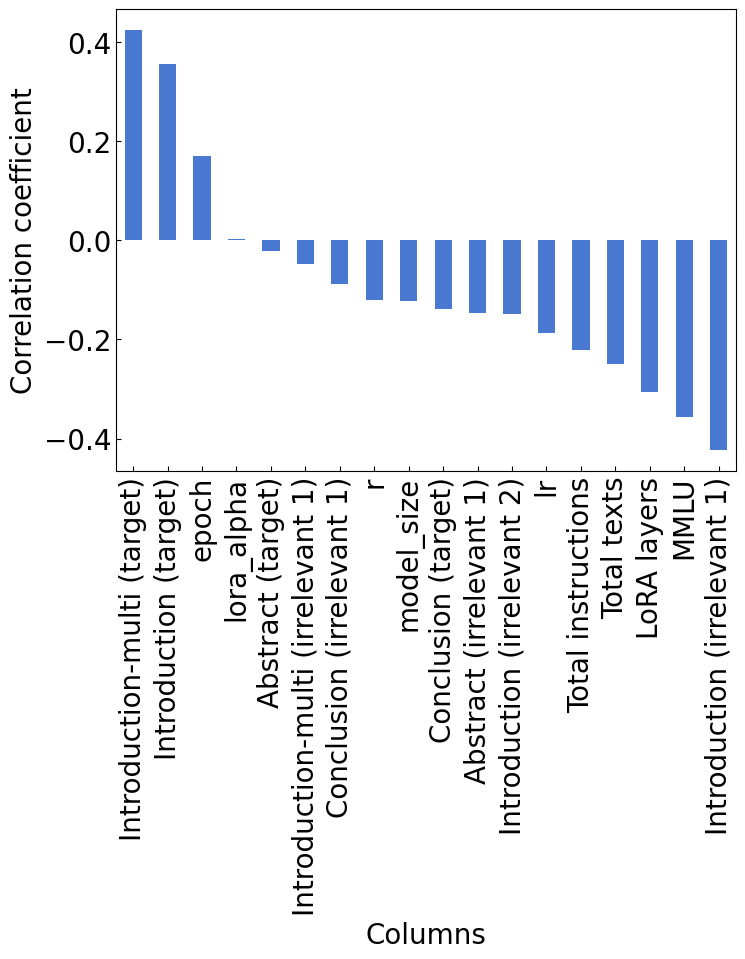

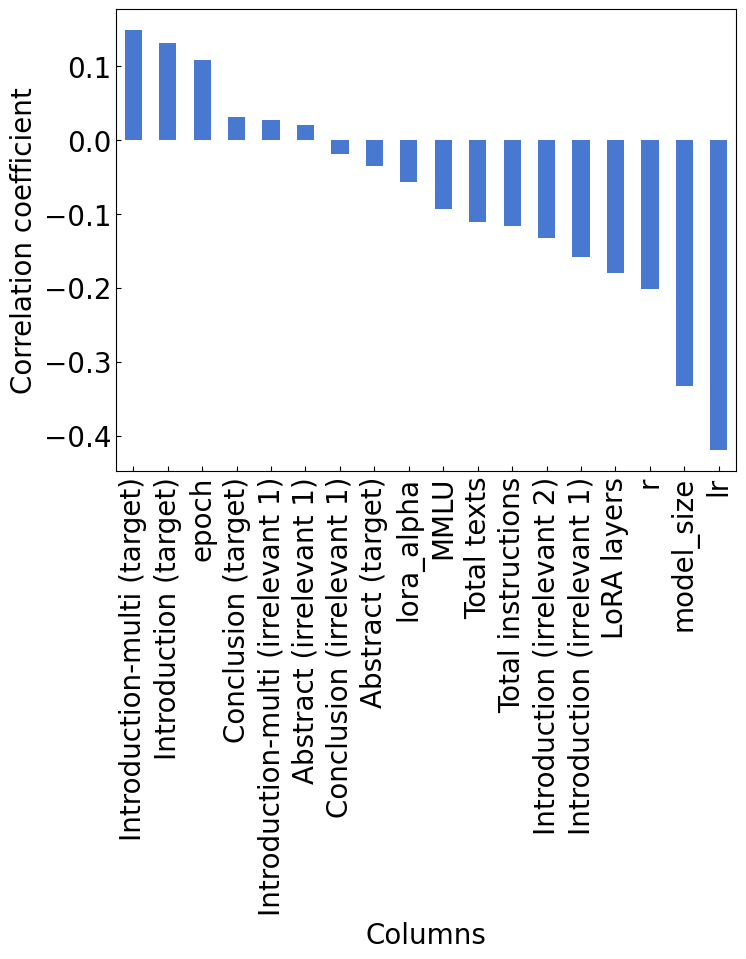

In [27]:
correlation=df.corr()["gen"].drop(["gen","score","mmlu","multi"]).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
correlation.plot(kind='bar')
#plt.title('Correlation with "gen" column')
plt.ylabel('Correlation coefficient')
plt.xlabel('Columns')
plt.show()

correlation=df.corr()["multi"].drop(["gen","score","mmlu","multi"]).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
correlation.plot(kind='bar')
#plt.title('Correlation with "mult" column')
plt.ylabel('Correlation coefficient')
plt.xlabel('Columns')
plt.show()

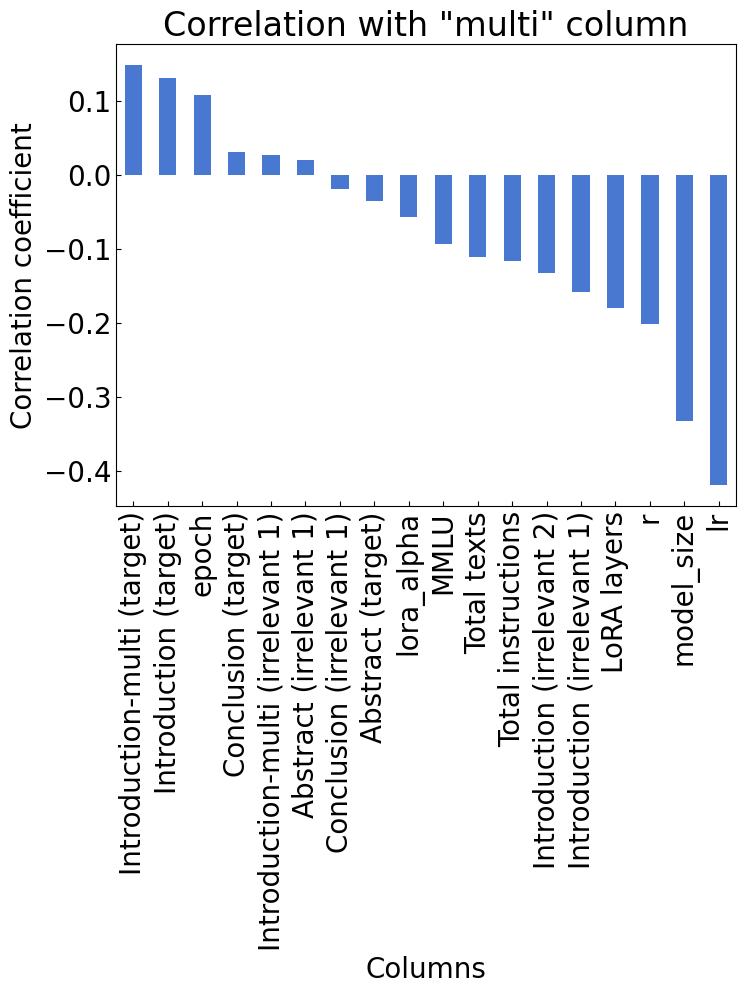

In [28]:

correlation=df.corr()["multi"].drop(["gen","score","mmlu","multi"]).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
correlation.plot(kind='bar')
plt.title('Correlation with "multi" column')
plt.ylabel('Correlation coefficient')
plt.xlabel('Columns')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


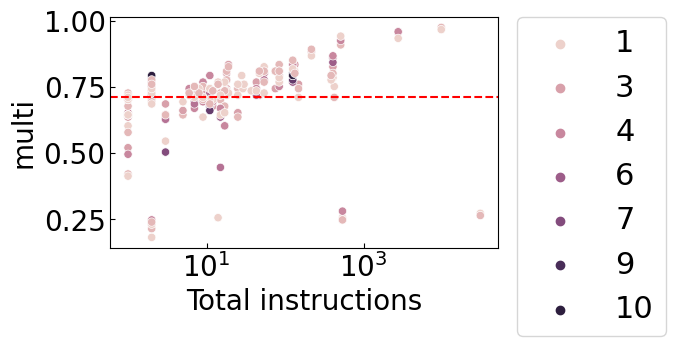

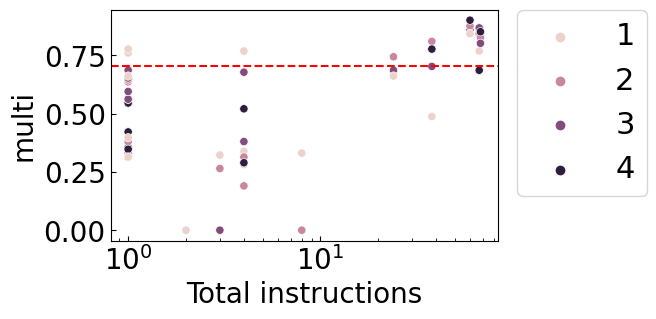

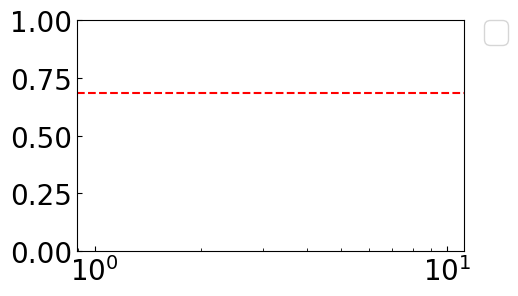

In [29]:

for size in [7,13,70]:
    plt.figure(figsize=(5,3))
    df_size=df[df["model_size"]==size]
    sns.scatterplot(data=df_size,x="Total instructions",y="multi",hue="epoch")
    plt.xscale("log")
    baseline=multi_baseline_dict[size]
    plt.axhline(y=baseline, color='r', linestyle='--')


    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=22)

<Axes: >

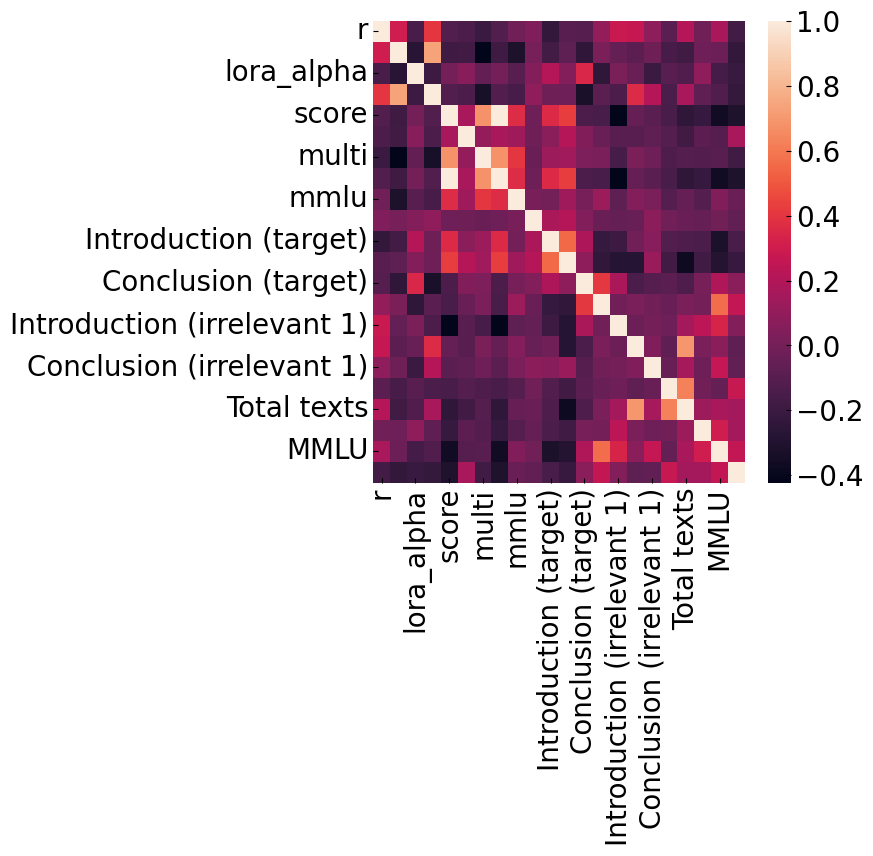

In [30]:
sns.heatmap(df.corr())

In [31]:
df_["pred_log"][12]

[{'problem': 'You are a great scientist. Answer the following question:\n[Question] Which specific metal pollutants can impact human skin?\nChoices:\n1. These toxic compounds are directly implicated in skin pathological processes such as premature ageing, atopic dermatitis, psoriasis, altered pigmentation, chronic wounds and cancer.\n2. In current human ecosystems, characterized in most cases by a sustained increase of life expectancy and a rapid environmental accumulation of human-derived bio-toxic waste materials, the cutaneous homeostatic and regenerative potential is also being critically impaired in an accelerated way by a concomitantly increasing concentration of several air pollutants.\n3. In particular, toxic Arsenic, Cadmium and Chromium compounds, for the most part released to the atmosphere as a result of anthropogenic activity, may have a significant impact on human skin.\n4. Metal and metalloid compounds are among the most common air pollutants as main components of ambien